In [1]:
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
from keras import backend as K
from keras.utils import to_categorical
import glob
import os
import segmentation_models_3D as sm
import nibabel as nib
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from scipy.ndimage import zoom
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

2023-06-10 23:15:46.993970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 23:15:47.151795: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


Segmentation Models: using `tf.keras` framework.


In [2]:
image_dir = '/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)'
mask_dir = '/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)'

#'/home/dnn4/pythonCodeArea/soham/New Folder
# image_path_t = glob.glob(r'/home/dnn4/pythonCodeArea/soham/New Folder/resized imgs(256)org/*.nii')
# mask_path_t = glob.glob(r'/home/dnn4/pythonCodeArea/soham/New Folder/resized masks(256)org/*.nii')

image_path_t = glob.glob(image_dir + '/*.nii.gz')
mask_path_t = glob.glob(mask_dir + '/*.nii.gz')

# image_path_t = glob.glob(os.path.join(image_dir, '*.nii'))
# mask_path_t = glob.glob(os.path.join(mask_dir, '*.nii'))

In [3]:
print("Number of image files:", len(image_path_t))
print("Number of mask files:", len(mask_path_t))

# Print the first few file paths for verification
print("Sample image file paths:")
for i in range(min(5, len(image_path_t))):
    print(image_path_t[i])

print("Sample mask file paths:")
for i in range(min(5, len(mask_path_t))):
    print(mask_path_t[i])

Number of image files: 38
Number of mask files: 38
Sample image file paths:
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K4-img.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K2-img.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K15-img.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K5-img.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/D17-img.nii.gz
Sample mask file paths:
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/D16-seg.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/D14-seg.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/K9-seg.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/K1-seg.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/K20-seg.nii.gz


In [4]:
img_arr=[]
mask_arr=[]
for x in image_path_t:
  im=nib.load(x)
  img=np.array(im.dataobj)
  img_arr.append(img)
for y in mask_path_t:
  ma=nib.load(y)
  mask=np.array(ma.dataobj)
  mask_arr.append(mask)

In [5]:
input_img=np.array(img_arr)
input_mask=np.array(mask_arr)
input_img=np.stack((input_img,)*3,axis=-1)
input_mask=np.expand_dims(input_mask,axis=-1)
input_img=input_img.astype(np.float32)
input_mask=input_mask.astype(np.float32)
print(input_img.shape)
print(input_mask.shape)

(38, 256, 256, 64, 3)
(38, 256, 256, 64, 1)


In [6]:
x_train, x_test, y_train, y_test= train_test_split(input_img,input_mask,test_size=0.2)
print(x_train.shape,y_test.shape)

(30, 256, 256, 64, 3) (8, 256, 256, 64, 1)


In [7]:
encoder_weights = 'imagenet'
BACKBONE = 'resnet34'  
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(), sm.metrics.FScore(),'binary_accuracy','Precision','Recall','AUC']

2023-06-10 23:15:55.364460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 23:15:55.393043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 23:15:55.393257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Linknet(BACKBONE,input_shape=(256,256,64,3),
                encoder_weights='imagenet',activation='sigmoid')
model.compile(optimizer = optim, loss=sm.losses.dice_loss, metrics=metrics)

254515160/254515160 [==============================] - 40s 0us/step


In [9]:
lrp=ReduceLROnPlateau(monitor="val_loss",  patience=2)
#es=EarlyStopping(patience=2,monitor='iou_score')
call=[lrp]
history=model.fit(x_train,y_train,
         batch_size=1,
         epochs=30,
         validation_data=(x_test,y_test),
         callbacks=call)

Epoch 1/30


2023-06-10 23:16:47.549816: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:405] Cancel Transpose nodes around Pad: transpose_before=model_1/bn_data/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=model_1/zero_padding3d/Pad transpose_after=model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/model_1/conv0/Conv3D/Conv3DBackpropFilterV2-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/model_1/conv0/Conv3D/ShapeN-0-TransposeNDHWCToNCDHW-LayoutOptimizer
2023-06-10 23:16:51.545809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-06-10 23:16:55.626836: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3e6f178820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-10 23:16:55.626864: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-06-10 23:16:55.

30/30 [==============================] - ETA: 0s - loss: 0.9877 - iou_score: 0.0062 - f1-score: 0.0123 - binary_accuracy: 0.7399 - precision: 0.0109 - recall: 0.8700 - auc: 0.8853

2023-06-10 23:17:17.024635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


30/30 [==============================] - 38s 296ms/step - loss: 0.9877 - iou_score: 0.0062 - f1-score: 0.0123 - binary_accuracy: 0.7399 - precision: 0.0109 - recall: 0.8700 - auc: 0.8853 - val_loss: 0.9920 - val_iou_score: 0.0040 - val_f1-score: 0.0080 - val_binary_accuracy: 0.0686 - val_precision: 0.0038 - val_recall: 1.0000 - val_auc: 0.8225 - lr: 1.0000e-04
Epoch 2/30
30/30 [==============================] - 6s 188ms/step - loss: 0.9819 - iou_score: 0.0092 - f1-score: 0.0181 - binary_accuracy: 0.8879 - precision: 0.0275 - recall: 0.9586 - auc: 0.9686 - val_loss: 0.9893 - val_iou_score: 0.0054 - val_f1-score: 0.0107 - val_binary_accuracy: 0.3769 - val_precision: 0.0057 - val_recall: 0.9984 - val_auc: 0.8604 - lr: 1.0000e-04
Epoch 3/30
30/30 [==============================] - 6s 187ms/step - loss: 0.9716 - iou_score: 0.0144 - f1-score: 0.0284 - binary_accuracy: 0.9294 - precision: 0.0428 - recall: 0.9547 - auc: 0.9744 - val_loss: 0.9852 - val_iou_score: 0.0075 - val_f1-score: 0.0148 -

Epoch 23/30
30/30 [==============================] - 6s 204ms/step - loss: 0.5223 - iou_score: 0.3176 - f1-score: 0.4777 - binary_accuracy: 0.9964 - precision: 0.4607 - recall: 0.5952 - auc: 0.8531 - val_loss: 0.9975 - val_iou_score: 0.0012 - val_f1-score: 0.0025 - val_binary_accuracy: 0.9964 - val_precision: 0.0902 - val_recall: 4.7876e-04 - val_auc: 0.5012 - lr: 1.0000e-10
Epoch 24/30
30/30 [==============================] - 6s 204ms/step - loss: 0.5223 - iou_score: 0.3176 - f1-score: 0.4777 - binary_accuracy: 0.9964 - precision: 0.4607 - recall: 0.5952 - auc: 0.8531 - val_loss: 0.9977 - val_iou_score: 0.0011 - val_f1-score: 0.0023 - val_binary_accuracy: 0.9964 - val_precision: 0.0884 - val_recall: 4.0316e-04 - val_auc: 0.5010 - lr: 1.0000e-11
Epoch 25/30
30/30 [==============================] - 6s 203ms/step - loss: 0.5224 - iou_score: 0.3176 - f1-score: 0.4776 - binary_accuracy: 0.9964 - precision: 0.4608 - recall: 0.5952 - auc: 0.8531 - val_loss: 0.9978 - val_iou_score: 0.0011 - v

In [10]:
#model.evaluate(x_test,y_test)
#score= model.evaluate(x_train,y_train,verbose=0)
results = model.evaluate(x_test, y_test, verbose=0)

# Retrieve and print all metrics
metrics_names = model.metrics_names
for metric_name, metric_value in zip(metrics_names, results):
    print(f"{metric_name}: {metric_value}")

loss: 0.9982796311378479
iou_score: 0.0008609252981841564
f1-score: 0.0017203694442287087
binary_accuracy: 0.9964377880096436
precision: 0.08510638028383255
recall: 0.0004031648568343371
auc: 0.25240835547447205


In [11]:
test_img = x_train[0]
ground_truth=y_train[0]
test_img_input=np.expand_dims(test_img, 0)
test_pred1 = model.predict(test_img_input)
test_prediction1=(test_pred1>=0.5)
test_prediction1=np.squeeze(test_prediction1,axis=-1)
test_prediction1=np.squeeze(test_prediction1,axis=0)
print(test_prediction1.shape)

1/1 [==============================] - 1s 564ms/step
(256, 256, 64)


In [12]:
ground_truth_argmax = ground_truth>=0.5
ground_truth_argmax = np.squeeze(ground_truth_argmax, axis = -1)
print(ground_truth_argmax.shape)
print(test_img.shape)

(256, 256, 64)
(256, 256, 64, 3)


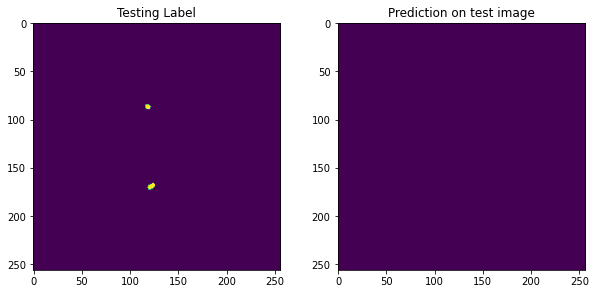

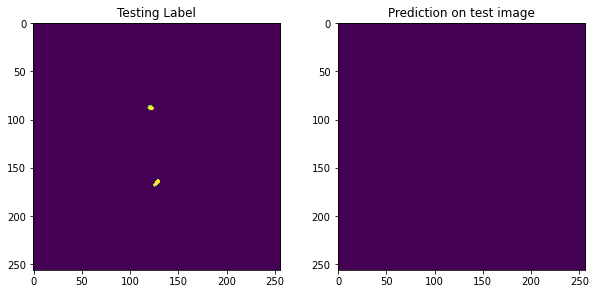

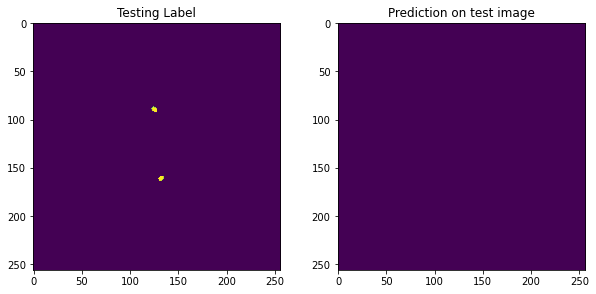

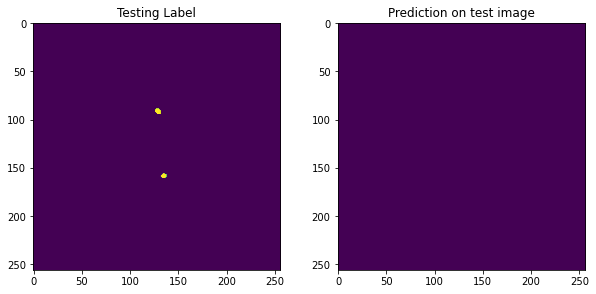

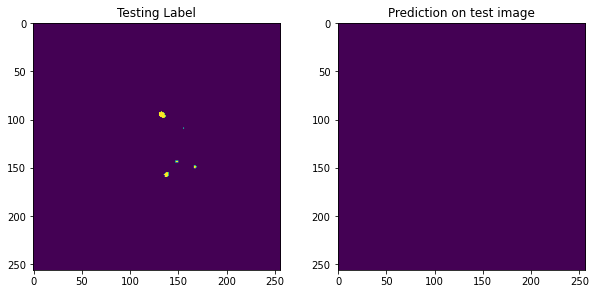

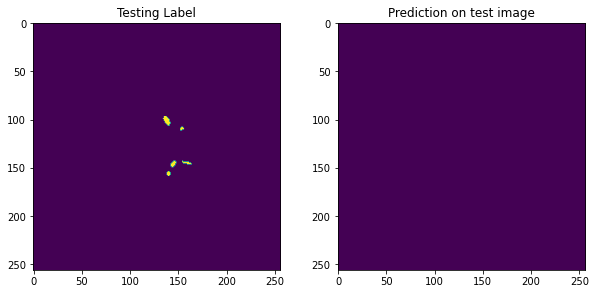

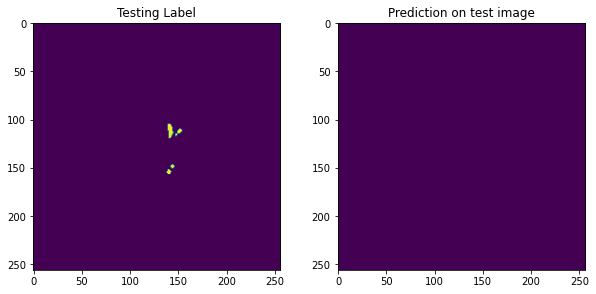

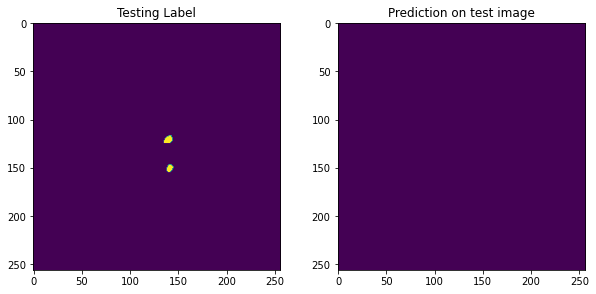

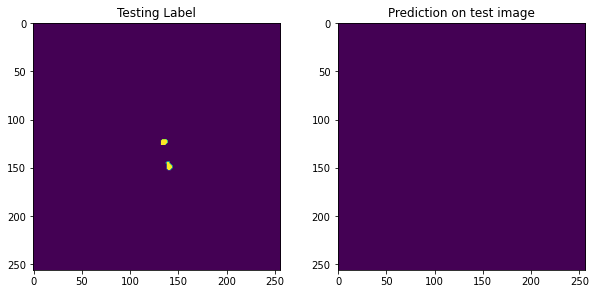

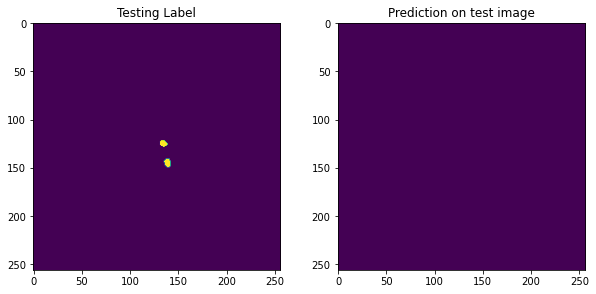

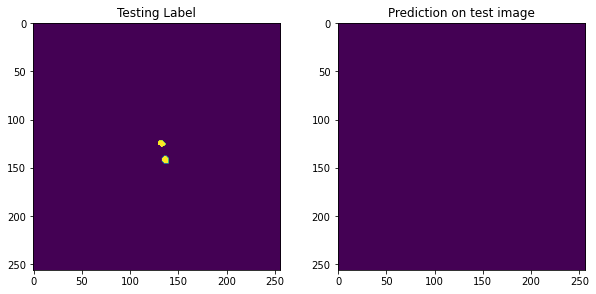

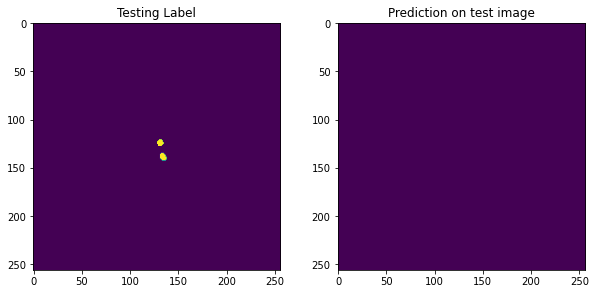

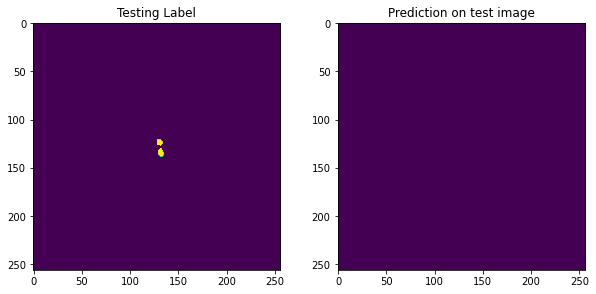

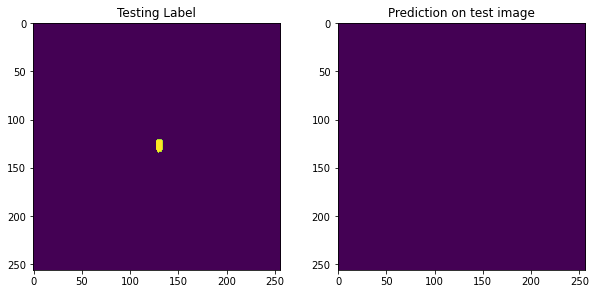

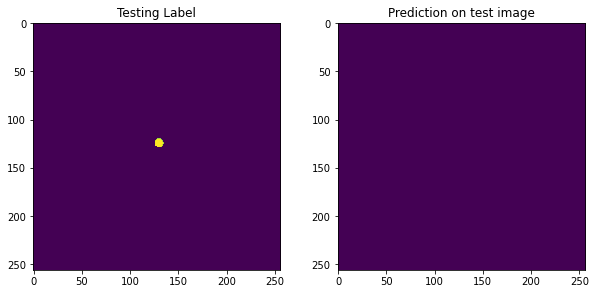

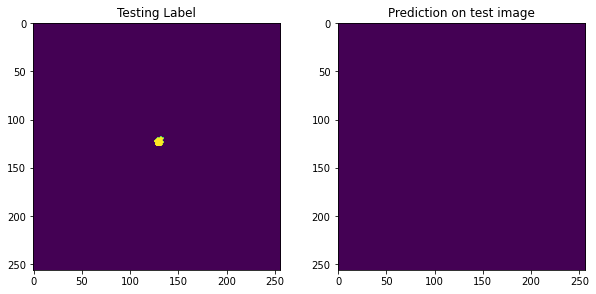

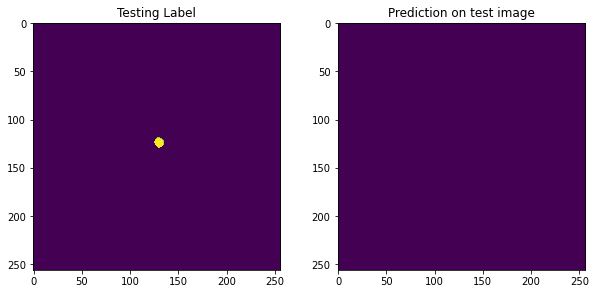

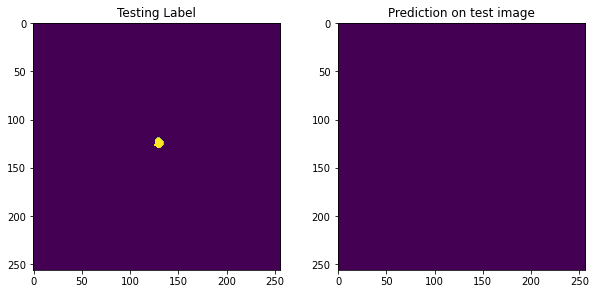

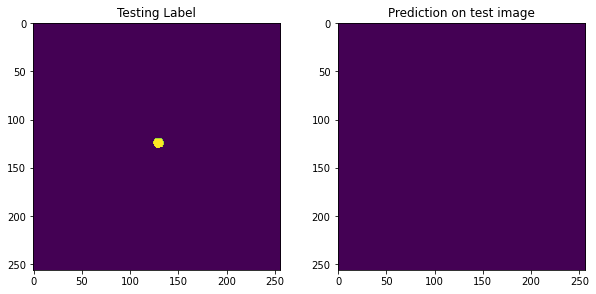

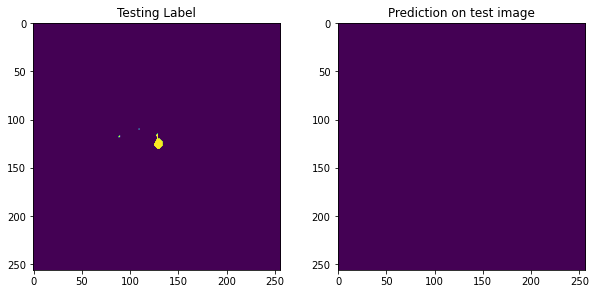

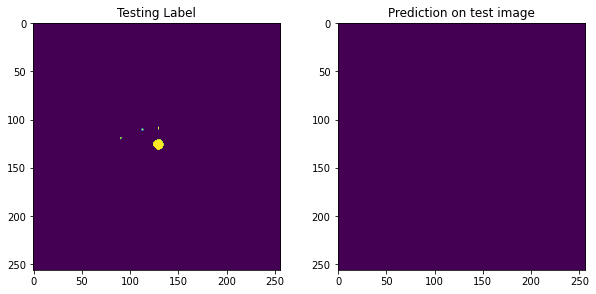

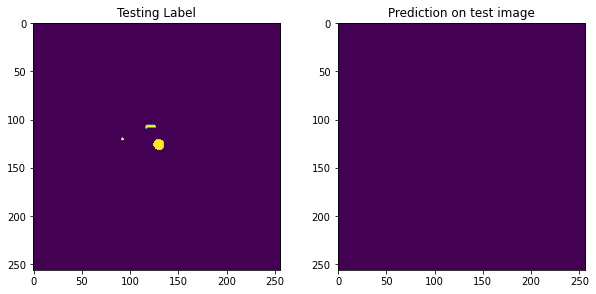

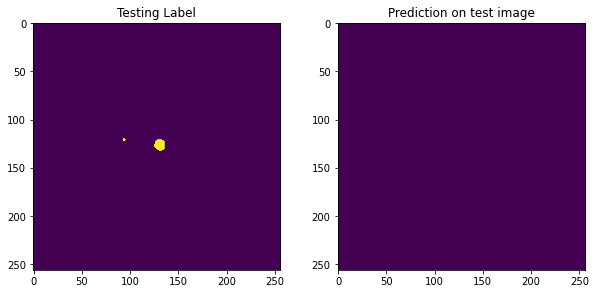

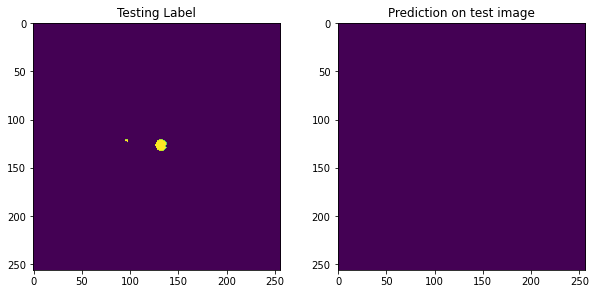

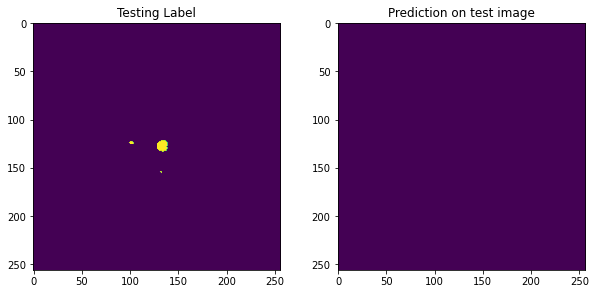

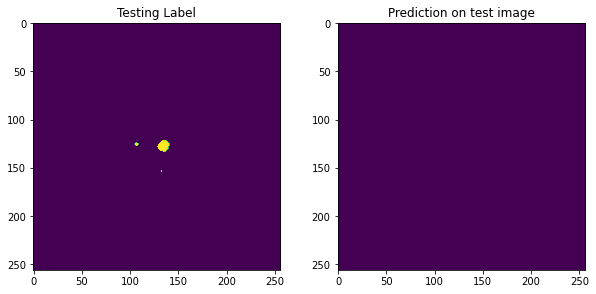

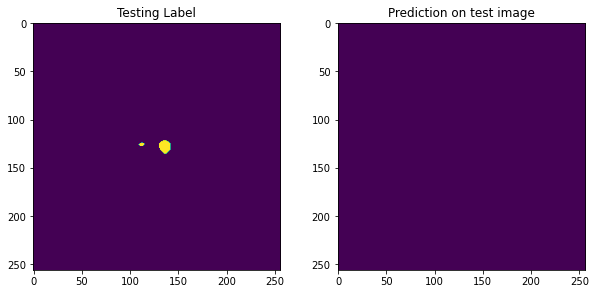

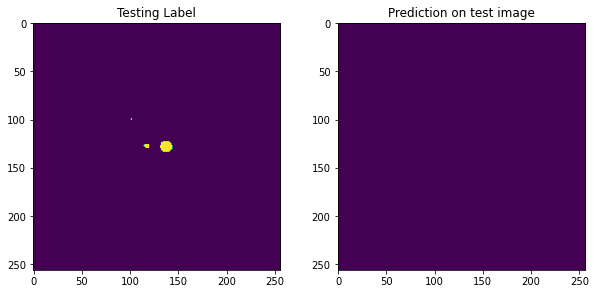

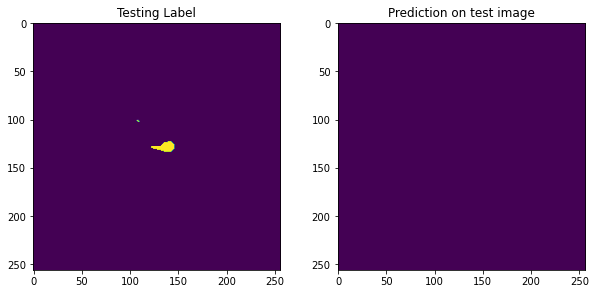

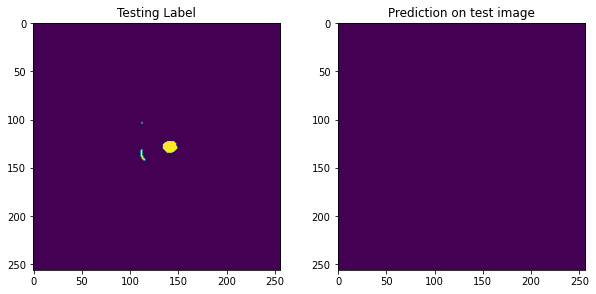

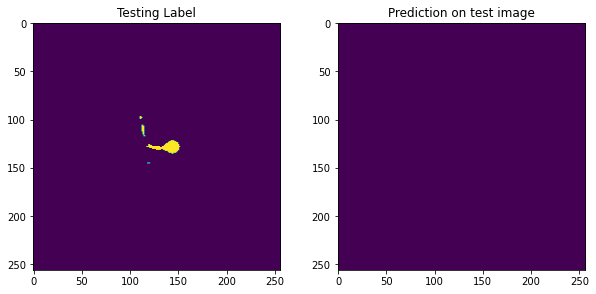

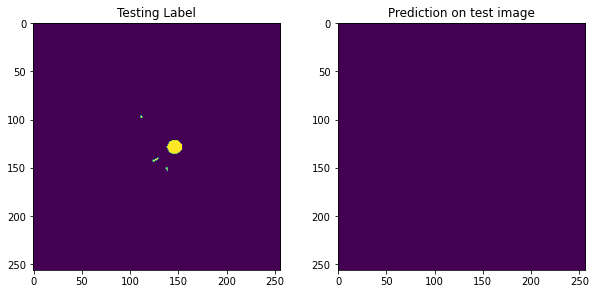

In [13]:
for x in range(32):
  plt.figure(figsize=(10,10)) 
  plt.subplot(221)
  plt.title('Testing Label')
  plt.imshow(ground_truth_argmax[:,:,x])
  plt.subplot(222)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction1[:,:,x])
  plt.show()

In [14]:
test_img=nib.load(r"/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K1-img.nii.gz")
test_im=np.array(test_img.dataobj)
test_img_input=np.stack((test_im,)*3, -1)
test_img_input=np.expand_dims(test_img_input,0)
print(test_img_input.shape)
test_pred1 = model.predict(test_img_input)
test_pred1=(test_pred1>=0.5)
#test_prediction1 = np.argmax(test_pred1, axis=4)
print(test_prediction1.shape)
print(np.unique(test_pred1))

(1, 256, 256, 64, 3)
1/1 [==============================] - 1s 538ms/step
(256, 256, 64)
[False]


In [15]:
reconstructed_image=np.reshape(test_pred1,(256,256,64))
reconstructed_image=reconstructed_image.astype(np.uint8)

In [16]:
print(test_img.affine)

[[   2.          0.          0.       -127.      ]
 [   0.          2.          0.       -127.      ]
 [   0.          0.         16.546875 -481.953125]
 [   0.          0.          0.          1.      ]]


In [17]:
out_img=nib.Nifti1Image(reconstructed_image,test_img.affine)
nib.save(out_img,'segmentation-output-k1 (1)')